This notebook considers:
1. __data.x2__ in data.py. It contains 69 features (initiator exclusive). 
2. From the result, we can find there is no difference with manual selected 23 features. We don't generate features in this notebook but we get rules for 23 features.
3. We use 69 features and change the order of the prediction to (sphere, vesicle, worm, other). But it doesn't make any differences.

In [1]:
import data1 as data
import random
from common import *
from rules import *
from realkd.patch import RuleFit
from sklearn.model_selection import cross_validate, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
import numpy as np
import matplotlib.colors as mcolors

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Full phase prediction


In [3]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.multioutput import ClassifierChain
from multilabel import BinaryRelevanceClassifier, ProbabilisticClassifierChain
from gam import LogisticGAM

STATE = np.random.RandomState(seed=1000)

lr = LogisticRegressionCV(penalty='l1', solver='saga', random_state=STATE)
lr_ind = BinaryRelevanceClassifier(lr)
lr_chain = ClassifierChain(lr, order=[0, 2, 1, 3])
lr_pcc = ProbabilisticClassifierChain(lr) 

# gams not fixed, remove this part.
# gam_ind = BinaryRelevanceClassifier(LogisticGAM(lam=20.0, max_iter=250))
# gam_chain = ClassifierChain(LogisticGAM(lam=20.0, max_iter=250))
# gam_pcc = ProbabilisticClassifierChain(LogisticGAM(lam=20.0, max_iter=250)) 

rf = RandomForestClassifier(random_state=STATE, min_samples_leaf=1, n_estimators=100)
rf_ind = BinaryRelevanceClassifier(rf)
rf_chain = ClassifierChain(rf, order=[0, 2, 1, 3])
rf_pcc = ProbabilisticClassifierChain(rf)

# Rulefit
rufit_pcc = RuleFitWrapper(mode='chain')

full_estimators = [lr_ind, lr_pcc, lr_chain, rf_ind, rf_pcc, rf_chain, rufit_pcc]
full_names = ['LR_ind', 'LR_pcc', 'LR_chain', 'RanF_ind', 'RanF_pcc', 'Ranf_chain', 'Ruf_pcc']

This following code under "2.6 GHz 6-Core Intel Core i7" runs ~5 hours. You can simply use saved result to re-run the result. (See below instructions)

```
import pickle
cur_save=open('./' + 'interpolation_30folder' + '.p', 'rb')
interpolation = pickle.load(cur_save)
```
After running these three-line code, you can ignore the following __interpolation__ code and re-run the rest.

Due to the individual prediction accuracy

In [6]:
from common import Experiment, LogLikelihoodEvaluator
from sklearn.model_selection import KFold

X = data.x.filter(data.predictors) # only consider the predictors

interpolation = Experiment(full_estimators, 
                    full_names,
                    KFold(30, shuffle=True, random_state=STATE),
                    data.x2, data.y.replace(-1.0, 0.0),
                    groups=data.comp_ids.array, 
                    evaluators=['accuracy', LogLikelihoodEvaluator(2, neg=True)],
                    verbose=True).run()

Running experiment with 30 repetitions
******************************


In [39]:
import pickle
cur_save=open('./' + 'interpolation_30folder_selected' + '.p', 'rb')
interpolation2 = pickle.load(cur_save)
df2 = interpolation2.summary()
df2 = df2.rename(index={'RF_ind': 'RanF_ind', 'RF_pcc': 'RanF_pcc', 'Rf_chain': 'Ranf_chain'})
df2.index = [each +'_selected' for each in df2.index.tolist()]
df2 # selected predictors

,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy,mean_train_log loss,std_train_log loss,mean_test_log loss,std_test_log loss
LR_ind_selected,0.382689,0.011744,0.378509,0.149020,2.908712,0.011742,2.929920,0.345263
LR_pcc_selected,0.382689,0.011744,0.378509,0.149020,2.908712,0.011742,2.929920,0.345263
LR_chain_selected,0.382689,0.011744,0.378509,0.149020,2.908712,0.011742,2.929920,0.345263
RanF_ind_selected,0.999825,0.000533,0.783421,0.070991,0.260965,0.004806,1.201244,0.810822
RanF_pcc_selected,0.999185,0.001356,0.800789,0.066668,0.245952,0.004644,1.163131,0.806772
Ranf_chain_selected,1.000000,0.000000,0.805614,0.067503,0.246824,0.004042,1.119475,0.721598
Rufit_pcc_selected,0.956489,0.004821,0.790702,0.084958,0.374151,0.008400,1.009409,0.412079


In [45]:
df1 = interpolation.summary()
df1 = df1.rename(index={'RF_ind': 'RanF_ind', 'RF_pcc': 'RanF_pcc', 'Rf_chain': 'Ranf_chain'})
df1.index = [each +'_all' for each in df1.index.tolist()]
df1 # selected predictors 69 variables

,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy,mean_train_log loss,std_train_log loss,mean_test_log loss,std_test_log loss
LR_ind_all,0.382689,0.011744,0.378509,0.149020,2.908712,0.011742,2.929920,0.345263
LR_pcc_all,0.382689,0.011744,0.378509,0.149020,2.908712,0.011742,2.929920,0.345263
LR_chain_all,0.382689,0.011744,0.378509,0.149020,2.908712,0.011742,2.929920,0.345263
RanF_ind_all,0.999825,0.000533,0.790439,0.081300,0.246749,0.004400,1.178788,0.820373
RanF_pcc_all,0.999301,0.001086,0.795614,0.063802,0.236409,0.003974,1.133042,0.813202
Ranf_chain_all,0.999767,0.000604,0.797105,0.069276,0.236690,0.003721,1.306564,1.060650
Rufit_pcc_all,0.955671,0.007447,0.787281,0.085572,0.370201,0.012714,1.030658,0.420191


In [47]:
import pandas as pd

df = pd.concat([df1, df2])
df = df.sort_index()
df

,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy,mean_train_log loss,std_train_log loss,mean_test_log loss,std_test_log loss
LR_chain_all,0.382689,0.011744,0.378509,0.149020,2.908712,0.011742,2.929920,0.345263
LR_chain_selected,0.382689,0.011744,0.378509,0.149020,2.908712,0.011742,2.929920,0.345263
LR_ind_all,0.382689,0.011744,0.378509,0.149020,2.908712,0.011742,2.929920,0.345263
LR_ind_selected,0.382689,0.011744,0.378509,0.149020,2.908712,0.011742,2.929920,0.345263
LR_pcc_all,0.382689,0.011744,0.378509,0.149020,2.908712,0.011742,2.929920,0.345263
LR_pcc_selected,0.382689,0.011744,0.378509,0.149020,2.908712,0.011742,2.929920,0.345263
RanF_ind_all,0.999825,0.000533,0.790439,0.081300,0.246749,0.004400,1.178788,0.820373
RanF_ind_selected,0.999825,0.000533,0.783421,0.070991,0.260965,0.004806,1.201244,0.810822
RanF_pcc_all,0.999301,0.001086,0.795614,0.063802,0.236409,0.003974,1.133042,0.813202
RanF_pcc_selected,0.999185,0.001356,0.800789,0.066668,0.245952,0.004644,1.163131,0.806772


## Get Baseline

* __Logloss__   
For a single sample with true label $y \in \{0,1\}$ and a probability estimate $p=P(y=1)$, the log loss is:
  
$$L = -(y\log(p) + (1-y)\log(1-p))$$.

* __Error Rate__
For a sample of $n$ observations, the probability of $k$ unique observation is $\{p_1, p_2, \dots, p_k\}$. The error rate is:

$$
E_{rr} = 1 - argmax \{p_i: p_i \in \{p_1, \dots, p_k\}\}
$$


In [48]:
def plot_summary(metric, summ, num_reps=30, baseline=None, names=None, colors = list(mcolors.BASE_COLORS.keys())):
    width = 0.35
    ind = np.arange(len(summ))
    plt.bar(ind-width/2, summ[f'mean_train_{metric}'], width=width, label='train', 
            yerr=summ[f'std_train_{metric}']/num_reps**0.5, capsize=3.0)
    plt.bar(ind+width/2, summ[f'mean_test_{metric}'], width=width, label='test',
            yerr=summ[f'std_test_{metric}']/num_reps**0.5, capsize=3.0)
    if baseline:
        for i in range(len(baseline)):
            plt.axhline(y=baseline[i], color=colors[i], linestyle='-', label=names[i])
    plt.ylabel(metric)
    plt.legend()
    plt.xticks(ind, summ.index)
    
df['mean_train_error'] = 1- df['mean_train_accuracy']
df['std_train_error'] = df['std_train_accuracy']
df['mean_test_error'] = 1- df['mean_test_accuracy']
df['std_test_error'] = df['std_test_accuracy']

In [49]:
# base line
uniq, cnt = np.unique(data.y.values, axis=0, return_counts=True) 
prob = cnt/sum(cnt)
info_logloss = sum(-1*prob * np.log2(prob))
print('Informed logloss: ', info_logloss)

uniprob = np.array([1/16 for _ in range(16)])
uninfo_logloss =  sum(-1*uniprob * np.log2(uniprob))
print('Uninformed logloss: ', uninfo_logloss)

Informed logloss:  2.5225679165070907
Uninformed logloss:  4.0


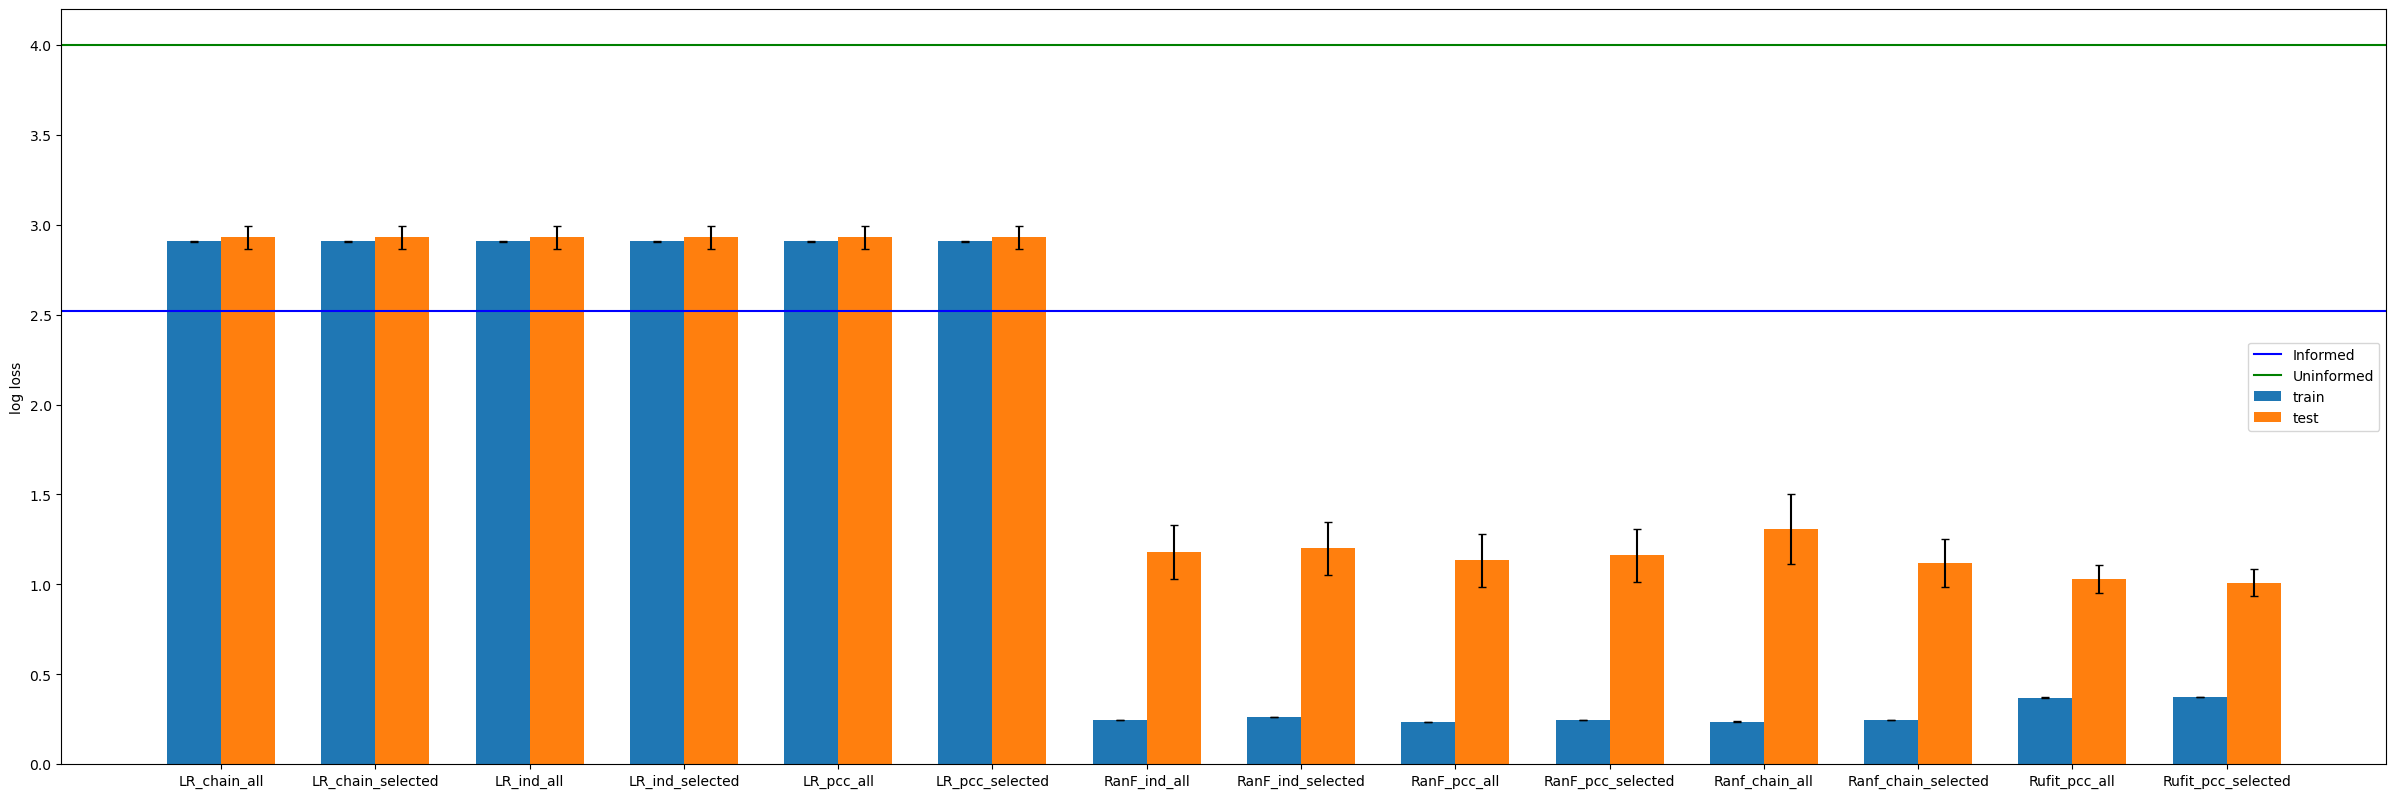

In [50]:
from matplotlib.pyplot import figure
figure(figsize=(30, 10), dpi=100)
plot_summary('log loss', summ=df, baseline=[info_logloss, uninfo_logloss], names=['Informed', 'Uninformed'])

In [51]:
# Error rate base line
uniq, cnts = np.unique(data.y.values, axis=0, return_counts=True)
prob = cnts/sum(cnts)
informed_error = 1- max(prob)
print('Informed Error: ', informed_error)

uninformed_error = 1-1/16
print('Uninformed Error: ', uninformed_error)

Informed Error:  0.5912162162162162
Uninformed Error:  0.9375


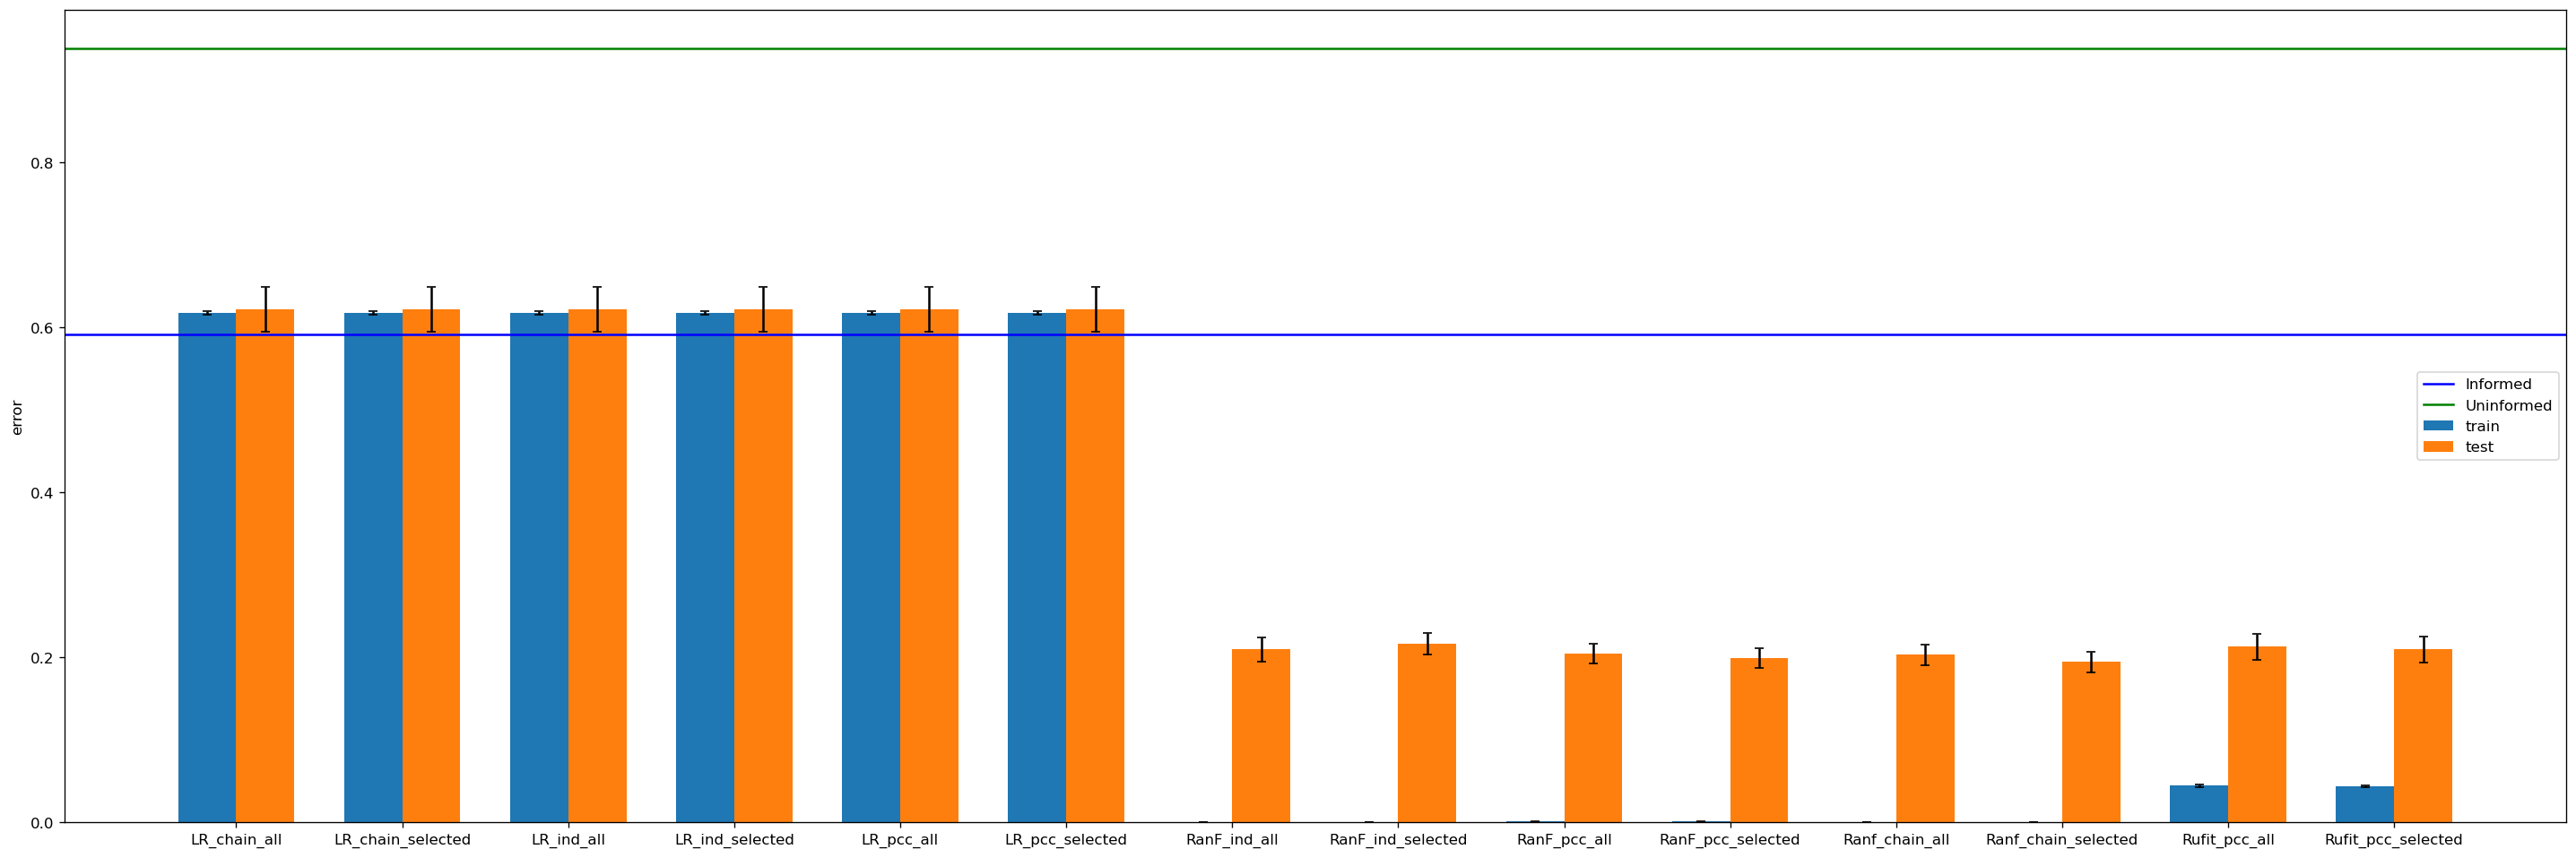

In [52]:
figure(figsize=(30, 10), dpi=120)
plot_summary('error', df, baseline=[informed_error, uninformed_error], names=['Informed', 'Uninformed']) # below plot is the error rate (1- accuracy)